In [1]:
%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as Functional

In [4]:
mathPlotLib.rcParams['image.cmap'] = 'plasma'

Data Setup
---

- Make Sure Data is normalized

In [7]:
xTraining,yTraining,xValidation,yValidation = getMnistData()

Make sure that the data is normalized, so that it has $\mu$ = 0 and $\sigma$ = 1

In [9]:
xTraining.mean(), xTraining.std()

(tensor(0.1304), tensor(0.3073))

Totally not normalized, let's fix that

In [48]:
xTrainingNormalized = normalizeVector(xTraining, xTraining.mean(), xTraining.std()).cuda()

In [49]:
xTrainingNormalized.mean(), xTrainingNormalized.std()

(tensor(9.9845e-05, device='cuda:0'), tensor(1.0000, device='cuda:0'))

# \\0/ 
Yay! Normalized!

Model Setup
---


In [50]:
rows, columns = xTrainingNormalized.shape
numberOfClasses = yTraining.max() + 1. # Largest digit to recognize :)
layerOutput = 75

In [51]:
numberOfClasses.item()

10

In [79]:
class DigitRecognitionModel(torch.nn.Module):
    def __init__(self, inputSize, numberOfClasses, layerOutput):
        super().__init__()
        self.layers = [torch.nn.Linear(inputSize, layerOutput), # Take in image vectors, output reduced matrix
                       torch.nn.ReLU(), # Perform activations
                       torch.nn.Linear(layerOutput, numberOfClasses)] # Predict digit classes.
        self.layers = [layer.cuda() for layer in self.layers]
    def __call__(self, trainingSet):
        layerInput = trainingSet
        for layer in self.layers: layerInput = layer(layerInput)
        return layerInput

In [80]:
digitReconModel = DigitRecognitionModel(columns, numberOfClasses.item(), layerOutput)

In [81]:
digitReconModel.layers

[Linear(in_features=784, out_features=75, bias=True),
 ReLU(),
 Linear(in_features=75, out_features=10, bias=True)]

In [86]:
rawPredictions = digitReconModel(xTrainingNormalized)

In [87]:
rawPredictions.shape

torch.Size([50000, 10])

In [88]:
rawPredictions

tensor([[-0.2421,  0.2581,  0.4019,  ...,  0.4451,  0.0326, -0.0482],
        [-0.2083,  0.1755, -0.1983,  ...,  0.3915,  0.1221, -0.0784],
        [ 0.2063,  0.1454,  0.1402,  ...,  0.1910, -0.2170, -0.1771],
        ...,
        [-0.0745, -0.0070,  0.1895,  ...,  0.4792,  0.2938, -0.2122],
        [-0.1981, -0.2195,  0.2124,  ...,  0.4679,  0.0144, -0.0259],
        [-0.1351, -0.1892,  0.0784,  ...,  0.0853,  0.0184, -0.1992]],
       device='cuda:0', grad_fn=<AddmmBackward>)

Loss Function
---

### Predictions

Your model has to predict something so that we cat teach it something.

First, we will need to compute the softmax of our **activations**. This is defined by:

$$\hbox{softmax}(\vec{x})_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

Which inturn turns the activations from the last layer into predictions of the probablity of belonging to one of the output classes.

$\hbox{exp}(constant) = e^{constant}$


In [97]:
def softMaxLoss(predictionVector):
    return (predictionVector.exp()/predictionVector.exp().sum(-1, keepdim=True))

In [98]:
predictions = softMaxLoss(rawPredictions)

In [99]:
predictions

tensor([[0.0711, 0.1172, 0.1354,  ..., 0.1414, 0.0936, 0.0863],
        [0.0754, 0.1107, 0.0762,  ..., 0.1374, 0.1050, 0.0859],
        [0.1123, 0.1057, 0.1051,  ..., 0.1106, 0.0735, 0.0765],
        ...,
        [0.0843, 0.0902, 0.1098,  ..., 0.1467, 0.1219, 0.0735],
        [0.0782, 0.0765, 0.1178,  ..., 0.1521, 0.0967, 0.0928],
        [0.0850, 0.0806, 0.1053,  ..., 0.1060, 0.0991, 0.0797]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [100]:
predictions.sum(-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward2>)

We can see that it outputs a bunch of ones when we sum the softmax vectors together, which is expected :D

*Apparently in practice you have to take the log of soft max to get something useful*

In [103]:
predicitonsLogged = predictions.log()

In [104]:
predicitonsLogged.sum(-1)

tensor([-23.2805, -23.2267, -23.1809,  ..., -23.2632, -23.2295, -23.1738],
       device='cuda:0', grad_fn=<SumBackward2>)

## Loss
### Entropy Loss

$$ -\sum x\, \log p(x) $$


**Step One: Figure out how to get validation data**

In [118]:
yTraining[96:99]

tensor([7, 8, 3])

These are the digits that each x is supposed to represent lets see!

The 96th is supposed to be a **7**

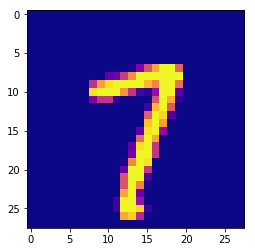

In [119]:
plotter.imshow(xTrainingNormalized[96].cpu().view(28,28))

Well would you look at that, ain't that neat?

Now let's see what our model thought how much this image looked like a **7**

In [122]:
predicitonsLogged[96][6]

tensor(-2.4450, device='cuda:0', grad_fn=<SelectBackward>)

# 🤔
Looks like it did not do a very good job, let's tell it what it needs to do to fix that

First, let's look at what our range looks like

predicitonsLogged[[96,97,98]]

Now let's remind ourselves what our expected digits are suppossed to be.

In [128]:
yTraining[96:99]

tensor([7, 8, 3])

**Combine all for profit**

In [130]:
predicitonsLogged[[96,97,98], [7,8,3]]

tensor([-2.0879, -2.2056, -2.3139], device='cuda:0', grad_fn=<IndexBackward>)

Now we can see what our model's predictions where for each of the digits. And they are all bad!

Let's now use this knowlege to perform

$$ -\sum x\, \log p(x) $$


In [131]:
def lossFundie(predictionVector, expectedVector): # expected vector is an array of numbers eg [4, 3, 9, 8] which correspond to each of the output classes.
    items = range(predictionVector.shape[0]) # 0 to 50000 iterator
    return -predictionVector[items, expectedVector].mean()

In [132]:
losses = lossFundie(predicitonsLogged, yTraining)

In [133]:
losses

tensor(2.3454, device='cuda:0', grad_fn=<NegBackward>)

### Enhanced LogMax!

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [144]:
def logMaxEnhanced(predictions):
    return predictions - predictions.logsumexp(-1, keepdim=True)

In [147]:
predictionsEnhanced = logMaxEnhanced(predicitonsLogged)

In [148]:
testNear(predictionsEnhanced, predictions)

AssertionError: near:
tensor([[-2.6436, -2.1435, -1.9996,  ..., -1.9564, -2.3689, -2.4498],
        [-2.5844, -2.2007, -2.5744,  ..., -1.9847, -2.2541, -2.4546],
        [-2.1866, -2.2475, -2.2527,  ..., -2.2018, -2.6099, -2.5700],
        ...,
        [-2.4728, -2.4054, -2.2089,  ..., -1.9192, -2.1046, -2.6105],
        [-2.5490, -2.5704, -2.1385,  ..., -1.8830, -2.3365, -2.3768],
        [-2.4647, -2.5189, -2.2513,  ..., -2.2444, -2.3113, -2.5289]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[0.0711, 0.1172, 0.1354,  ..., 0.1414, 0.0936, 0.0863],
        [0.0754, 0.1107, 0.0762,  ..., 0.1374, 0.1050, 0.0859],
        [0.1123, 0.1057, 0.1051,  ..., 0.1106, 0.0735, 0.0765],
        ...,
        [0.0843, 0.0902, 0.1098,  ..., 0.1467, 0.1219, 0.0735],
        [0.0782, 0.0765, 0.1178,  ..., 0.1521, 0.0967, 0.0928],
        [0.0850, 0.0806, 0.1053,  ..., 0.1060, 0.0991, 0.0797]],
       device='cuda:0', grad_fn=<DivBackward0>)